In [ ]:
import os, re
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

# 1) Overview

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to be a chatbot. This is an advanced example that assumes knowledge of [text generation](https://tensorflow.org/alpha/tutorials/text/text_generation), [attention](https://www.tensorflow.org/alpha/tutorials/text/nmt_with_attention) and [transformer](https://www.tensorflow.org/alpha/tutorials/text/transformer).


We will use the conversations in movies and TV shows provided by [Cornell Movie-Dialogs Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html), which contains more than 220 thousands conversational exchanges between more than 10k pairs of movie characters, as our dataset.

`movie_conversations.txt` contains list of the conversation IDs and `movie_lines.text` contains the text of assoicated with each conversation ID. For further  information regarding the dataset, please check the README file in the zip file.


# 2) Data Import

In [ ]:
# download dataå
path_to_zip = tf.keras.utils.get_file(
    './data',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")
path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset, 'movie_conversations.txt')

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # creating a space between a word and the punctuation following it, eg: "he is a boy." => "he is a boy ."
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
id2line = {}
MAX_SAMPLE = 1000
questions, answers = [], []

with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
    for i in range(len(conversation) - 1):
        questions.append(preprocess_sentence(id2line[conversation[i]]))
        answers.append(preprocess_sentence(id2line[conversation[i + 1]]))
    # control sample size
    if len(questions) >= MAX_SAMPLE:
        break
print(len(questions), len(answers))

1000 1000


# 3) Data Processing

## 3.1 Tokenization and Padding

In [ ]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
MAX_LEN = 40

# Tokenize, filter and pad sentences
def tokenize_and_filter(inputs, outputs, ):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        if len(sentence1) <= MAX_LEN and len(sentence2) <= MAX_LEN:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_inputs, maxlen=MAX_LEN, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(tokenized_outputs, maxlen=MAX_LEN, padding='post')
    return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('Vocab size: {}'.format(VOCAB_SIZE))
print('Number of samples: {}'.format(len(questions)))

Vocab size: 3015
Number of samples: 961


## 3.2 Data Preparation

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# remove START_TOKEN from targets as decoder inputs use the previous target as input
dataset = tf.data.Dataset.from_tensor_slices((
    {'inputs': questions, 'dec_inputs': answers[:, :-1]},
    {'outputs': answers[:, 1:]}
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
example_batch = next(iter(dataset))
example_inputs = example_batch[0]['inputs']
example_dec_inputs = example_batch[0]['dec_inputs']
example_dec_inputs = example_batch[1]['outputs']
print(example_inputs.shape, example_dec_inputs.shape, example_dec_inputs.shape)

(64, 40) (64, 39) (64, 39)


# 4) Attention

## 4.1 Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}} + M) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax.

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

Masking is needed to prevent the attention mechanism of a transformer from “cheating” in the decoder or peeking to the future. The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights.
    Args:
    q: query shape == (m, n_heads, seq_len_q, depth)
    k: key shape == (m, n_heads, seq_len_k, depth)
    v: value shape == (m, n_heads, seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable to (m, n_heads, seq_len_q, seq_len_k). Defaults to None.
    """

    # matmul is dot product of last 2 axis
    matmul_qk = tf.matmul(query, key, transpose_b=True) # （m, n_heads, seq_len_q, seq_len_k）
    depth = tf.cast(tf.shape(key)[-1], tf.float32) # 40, shape=()
    logits = matmul_qk / tf.math.sqrt(depth) # （m, n_heads, seq_len_q, seq_len_k）

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1) # （m, n_heads, seq_len_q, seq_len_k）
    output = tf.matmul(attention_weights, value) # (m, num_heads, seq_len_q, depth)
    return output

## 4.2 Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model # embedding dim
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # (m, seq_len, num_heads, depth)
        return tf.transpose(inputs, perm=[0, 2, 1, 3]) # (m, num_heads, seq_len, depth)

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0] # m

        # linear layers
        query = self.query_dense(query) # (m, seq_len_q, emb_dim)
        key = self.key_dense(key) # (m, seq_len_k, emb_dim)
        value = self.value_dense(value) # (m, seq_len_v, emb_dim)

        # split heads, emb_dims are split into different heads
        query = self.split_heads(query, batch_size) # (m, num_heads, seq_len_q, depth)
        key = self.split_heads(key, batch_size) # (m, num_heads, seq_len_k, depth)
        value = self.split_heads(value, batch_size) # (m, num_heads, seq_len_v, depth)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask) # (m, num_heads, seq_len_q, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # (m, seq_len_q, num_heads, depth)

        # concatenation of heads
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model)) # (m, seq_len, emb_dim)

        # final linear layer
        outputs = self.dense(concat_attention) # (m, seq_len, emb_dim)

        return outputs

# 5) Transformer

<img src="https://miro.medium.com/max/2880/1*BHzGVskWGS_3jEcYYi6miQ.png" width="400" alt="multi-head attention">

## 5.1 Masking

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [ ]:
# Mask all the pad tokens (value 0) in the batch to ensure the model does not treat padding as input.

def create_padding_mask(x):
    '''turn padding into 1, all 1 will be multiplied by -1e9'''
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :] # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(x):
    '''Mask the future word'''
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) # (target_seq_len, target_seq_len)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]]))

<tf.Tensor: shape=(1, 1, 5, 5), dtype=float32, numpy=
array([[[[0., 1., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 1., 1.],
         [0., 0., 1., 0., 1.],
         [0., 0., 1., 0., 0.]]]], dtype=float32)>

## 5.2 Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model) # (1, seq_len, emb_dim)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32)) # (1, emb_dim)
        return position * angles # (seq_len, emb_dim)

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis], # (seq_len, 1)
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # (1, emb_dim)
            d_model=d_model) # emb_dim, shape=()

        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2]) # (seq_len, emb_dim / 2)
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2]) # (seq_len, emb_dim / 2)

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...] # (1, seq_len, emb_dim)
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

## 5.3 Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask)
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # (m, seq_len, emb_dim)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask") # (m, 1, 1, None)

    attention = MultiHeadAttention(d_model, num_heads, name="attention")({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask}) # (m, seq_len_q, emb_dim)

    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    # residual layer: input+attention --> normalization
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention) # (m, seq_len, emb_dim)

    # feed forward
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention) # (m, seq_len, n_h)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs) # (m, seq_len, emb_dim)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs) # (m, seq_len, emb_dim)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None, ), name="inputs") # (m, seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask") # (m, 1, 1, None)
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs) # (m, seq_len, emb_dim)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings) # (m, seq_len, emb_dim)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # multiple layers
    for i in range(num_layers):
        outputs = encoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout,
                                name="encoder_layer_{}".format(i),)([outputs, padding_mask]) # (m, seq_len, emb_dim)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [ ]:
sample_encoder = encoder(vocab_size=8192, num_layers=2, units=512, d_model=128, num_heads=4, dropout=0.3, name="sample_encoder")

## 5.4 Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs") # (m, target_seq_len, emb_dim)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs") # (m, inp_seq_len, emb_dim)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask") # (1, target_seq_len, seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask') #(m, 1, 1, target_seq_len)

    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    }) # (m, target_seq_len, emb_dim)

    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention1 + inputs) # (m, target_seq_len, emb_dim)

    attention2 = MultiHeadAttention(d_model, num_heads, name="attention_2")(inputs={
        'query': attention1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
      }) # (m, target_seq_len, emb_dim)

    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention2 + attention1) # (m, target_seq_len, emb_dim)

    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2) # (m, target_seq_len, emb_dim)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs') # (m, target_seq_len)
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs') # (m, inp_seq_len, emb_dim)
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask') # (1, target_seq_len, seq_len)
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask') # (m, 1, 1, target_seq_len)

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs) # (m, target_seq_len, emb_dim)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings) # (m, target_seq_len, emb_dim)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings) # (m, target_seq_len, emb_dim)

    for i in range(num_layers):
        outputs = decoder_layer(units=units, d_model=d_model, num_heads=num_heads, dropout=dropout,
                                name=f'decoder_layer_{i}')(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

In [ ]:
sample_decoder = decoder(vocab_size=8192, num_layers=2, units=512, d_model=128,num_heads=4,
                         dropout=0.3,name="sample_decoder")

# 6) Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [ ]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):

    # inputs and mask
    inputs = tf.keras.Input(shape=(None,), name="inputs") # (m, inp_seq_len)
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs") # (m, target_inp_seq_len)

    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs) # (m, 1, 1, inp_seq_len)
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs) #(1, target_seq_len, targets_seq_len)
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs) # (m, 1, 1, inp_seq_len)

    # encoder
    enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, units=units,
                          d_model=d_model, num_heads=num_heads, dropout=dropout)(inputs=[inputs, enc_padding_mask]) # (m, input_seq_len, emb_dim)
    dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, units=units, d_model=d_model,
                          num_heads=num_heads, dropout=dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask]) # (m, target_seq_len, emb_dim)

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs) # (m, target_seq_len, vocab_size)
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
sample_transformer = transformer(vocab_size=8192, num_layers=4, units=512, d_model=128,
                                 num_heads=4, dropout=0.3, name="sample_transformer")


# 7) Model Training

## 7.1 Initialize model

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

In [ ]:
model = transformer(vocab_size=VOCAB_SIZE, num_layers=NUM_LAYERS,
                    units=UNITS, d_model=D_MODEL, num_heads=NUM_HEADS, dropout=DROPOUT)

## 7.2 Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [ ]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LEN - 1))
    # SparseCategoricalCrossentropy as y_pred.shape = (m, seq_len, voab_size), while y_true.shape = (m, seq_len)
    # logit=True to normalized output, similar to softmax
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

## 7.3 Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

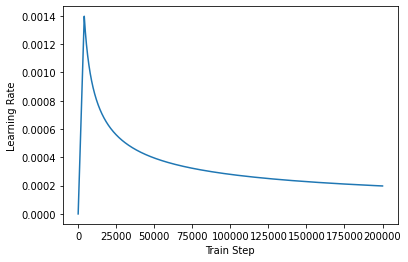

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128, warmup_steps=4000)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 7.4 Compile Model


In [ ]:
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LEN - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LEN - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 200
model.fit(dataset, epochs=EPOCHS)

Epoch 1/100
16/16 [==============================] - 1s 56ms/step - loss: 0.0048 - accuracy: 0.2911
Epoch 2/100
16/16 [==============================] - 1s 49ms/step - loss: 0.0053 - accuracy: 0.2911
Epoch 3/100
16/16 [==============================] - 1s 51ms/step - loss: 0.0060 - accuracy: 0.2907
Epoch 4/100
16/16 [==============================] - 1s 49ms/step - loss: 0.0078 - accuracy: 0.2904
Epoch 5/100
16/16 [==============================] - 1s 49ms/step - loss: 0.0086 - accuracy: 0.2901
Epoch 6/100
16/16 [==============================] - 1s 50ms/step - loss: 0.0101 - accuracy: 0.2895
Epoch 7/100
16/16 [==============================] - 1s 49ms/step - loss: 0.0116 - accuracy: 0.2889
Epoch 8/100
16/16 [==============================] - 1s 51ms/step - loss: 0.0162 - accuracy: 0.2879
Epoch 9/100
16/16 [==============================] - 1s 51ms/step - loss: 0.0136 - accuracy: 0.2884
Epoch 10/100
16/16 [==============================] - 1s 50ms/step - loss: 0.0126 - accuracy: 0.2888

## 7.5 Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`.
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [ ]:
MAX_LENGTH = 40

def evaluate(sentence):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    output = tf.expand_dims(START_TOKEN, 0)

    # the output length will go like 1, 2, 3...Max_Length
    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)
        print(predictions.shape)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder as its input.
        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0)

def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])
    print('Input: {}'.format(sentence))
    print('Output: {}'.format(predicted_sentence))
    return predicted_sentence

In [ ]:
output = predict('Where have you been?')

(1, 1, 3015)
(1, 2, 3015)
(1, 3, 3015)
(1, 4, 3015)
(1, 5, 3015)
(1, 6, 3015)
(1, 7, 3015)
Input: Where have you been?
Output: nowhere . . . hi , daddy .


In [ ]:
output = predict("It's a trap")

Input: It's a trap
Output: i didn t have a choice .


In [ ]:
# feed the model with its previous output
sentence = 'I am not crazy, my mother had me tested.'
for _ in range(5):
    sentence = predict(sentence)
    print('')

Input: I am not crazy, my mother had me tested.
Output: oh ? so you are a new man ?

Input: oh ? so you are a new man ?
Output: i don t know . . . i have the impression that i didn t change that much . i still can t accept the world as it is !

Input: i don t know . . . i have the impression that i didn t change that much . i still can t accept the world as it is !
Output: you don t care about that either . prettiest suspect i ve had in awhile .

Input: you don t care about that either . prettiest suspect i ve had in awhile .
Output: who says she s a suspect ?

Input: who says she s a suspect ?
Output: then to go out with her if you had the cake ?

